In [2]:
!pip install scanpy --user

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc

In [3]:
sc.settings.verbosity = 3
sc.logging.print_versions()
results_file = './write/kidney_allograft_rejection.h5ad'

scanpy==1.4.4.post1 anndata==0.6.22.post1 umap==0.3.10 numpy==1.16.4 scipy==1.3.0 pandas==0.25.3 scikit-learn==0.21.2 statsmodels==0.10.0 python-igraph==0.7.1 louvain==0.6.1


In [4]:
sc.settings.set_figure_params(dpi=80)

In [1]:
!pwd
!ls kidney_allograft_rejection/

/Users/khunzawlatt/Desktop/Python_course/sc309
Kidney.biopsy.dge.txt                  Kidney_allo_rejection_python_input.txt


In [5]:
adata = sc.read_text(
    '/Users/khunzawlatt/Desktop/Python_course/sc309/kidney_allograft_rejection/Kidney_allo_rejection_python_input.txt')  # the directory with the `.mtx` file
    # use gene symbols for the variable names (variables-axis index)

normalizing by total count per cell
    finished (0:00:01): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


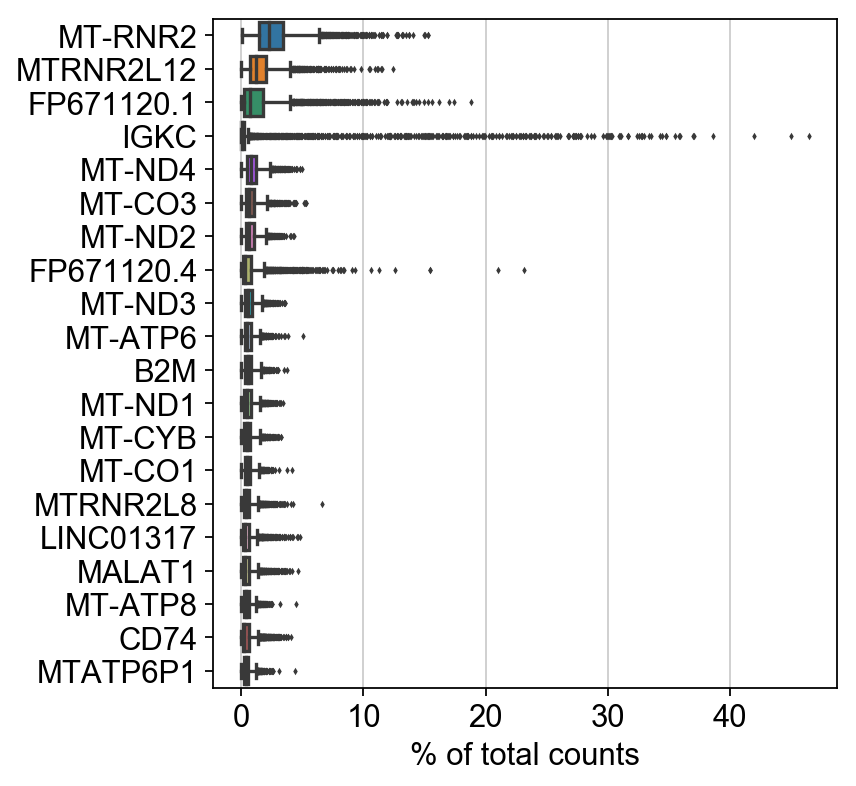

In [6]:
sc.pl.highest_expr_genes(adata, n_top=20)

In [7]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [10]:
mito_genes = adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1)

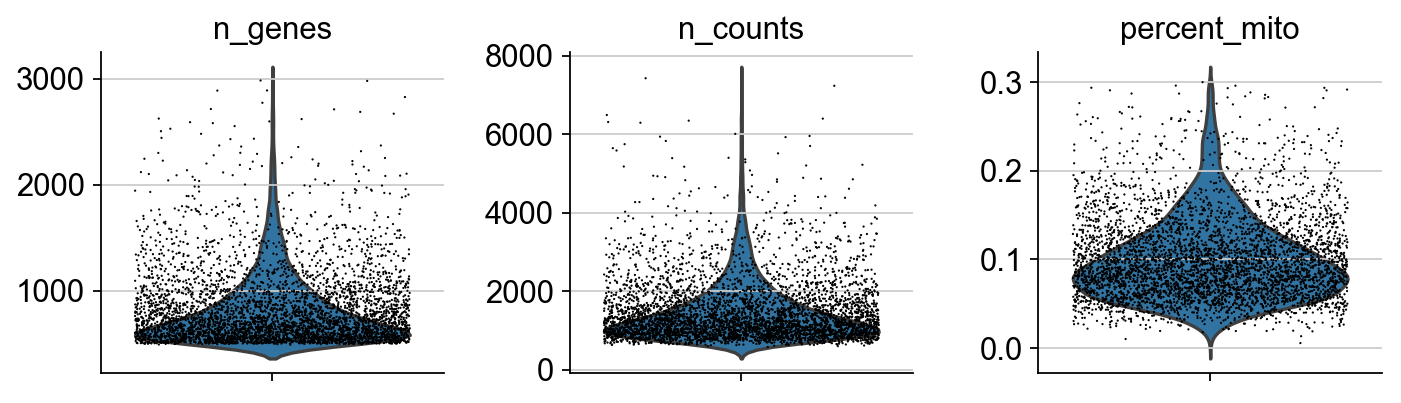

In [11]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)

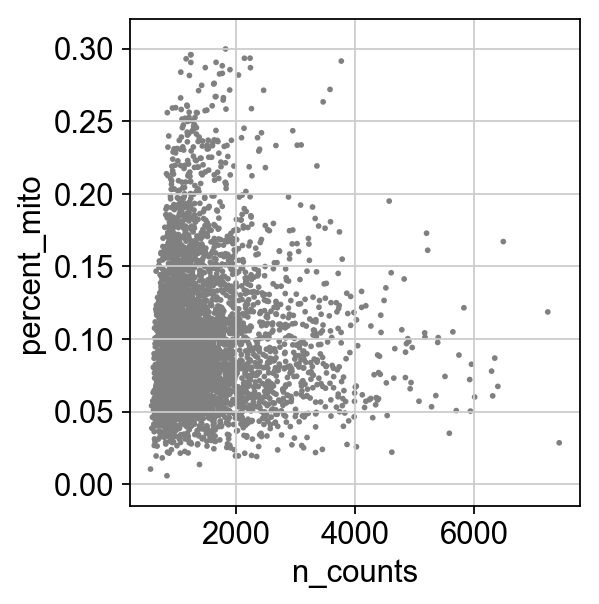

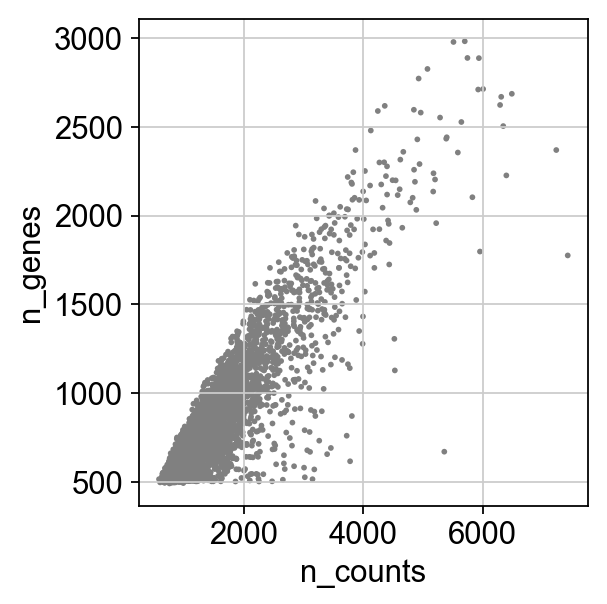

In [12]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [13]:
adata

AnnData object with n_obs × n_vars = 4487 × 20477 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'n_cells'

In [14]:
adata = adata[adata.obs['n_genes'] < 2500, :]
adata = adata[adata.obs['percent_mito'] < 0.05, :]

In [15]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

normalizing by total count per cell


Trying to set attribute `.obs` of view, making a copy.


    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [16]:
sc.pp.log1p(adata)

In [18]:
adata.raw = adata

In [19]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


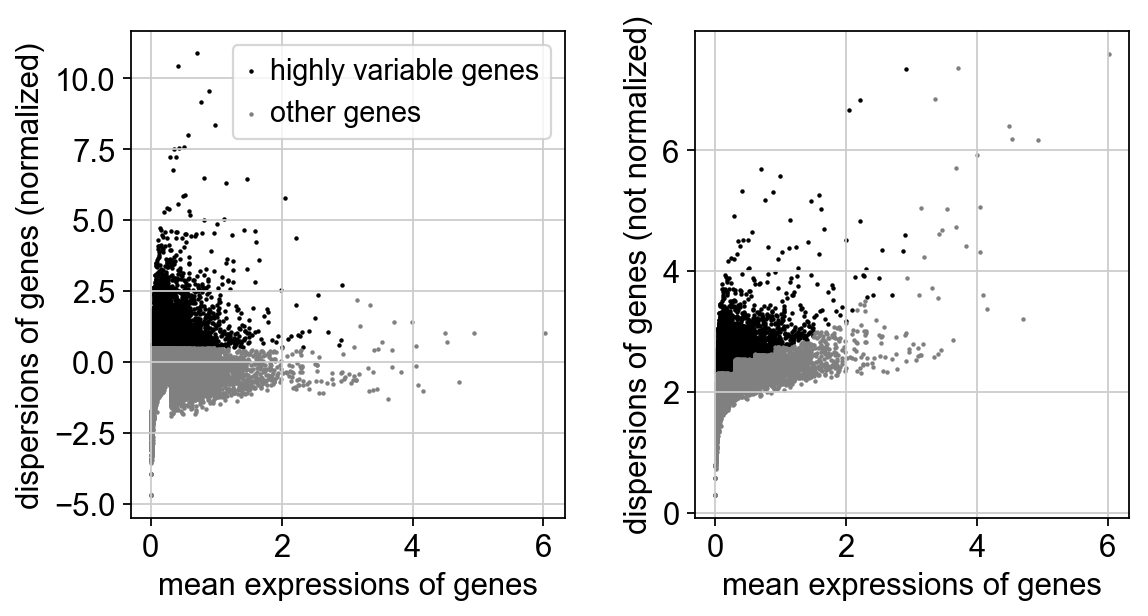

In [20]:
sc.pl.highly_variable_genes(adata)

In [21]:
adata = adata[:, adata.var['highly_variable']]

In [22]:
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])

regressing out ['n_counts', 'percent_mito']


//anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


    finished (0:00:19)


In [23]:
sc.pp.scale(adata, max_value=10)

In [24]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:00)


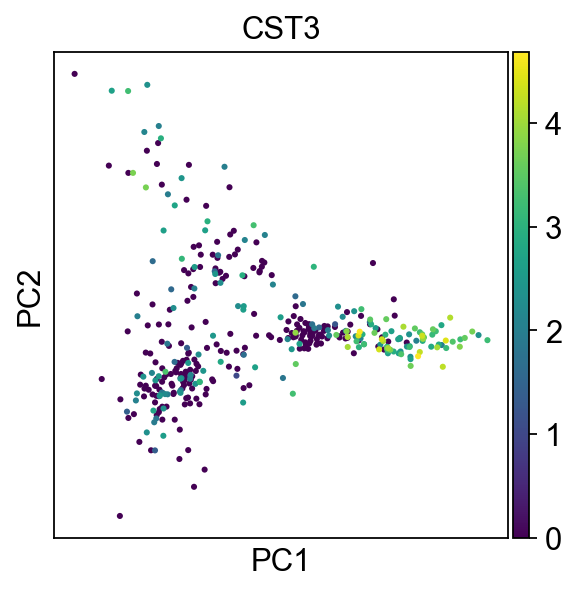

In [31]:
sc.pl.pca(adata, color='CST3', size=30)

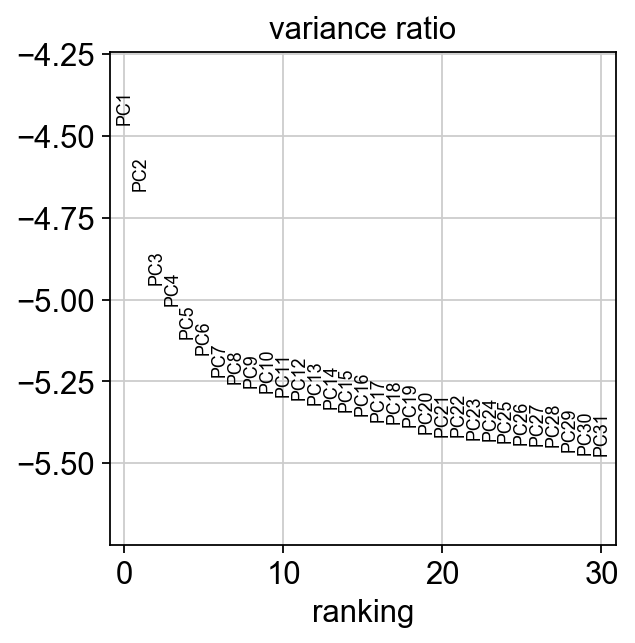

In [26]:
sc.pl.pca_variance_ratio(adata, log=True)

In [32]:
adata.write(results_file)

In [33]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:03)


In [35]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:02)


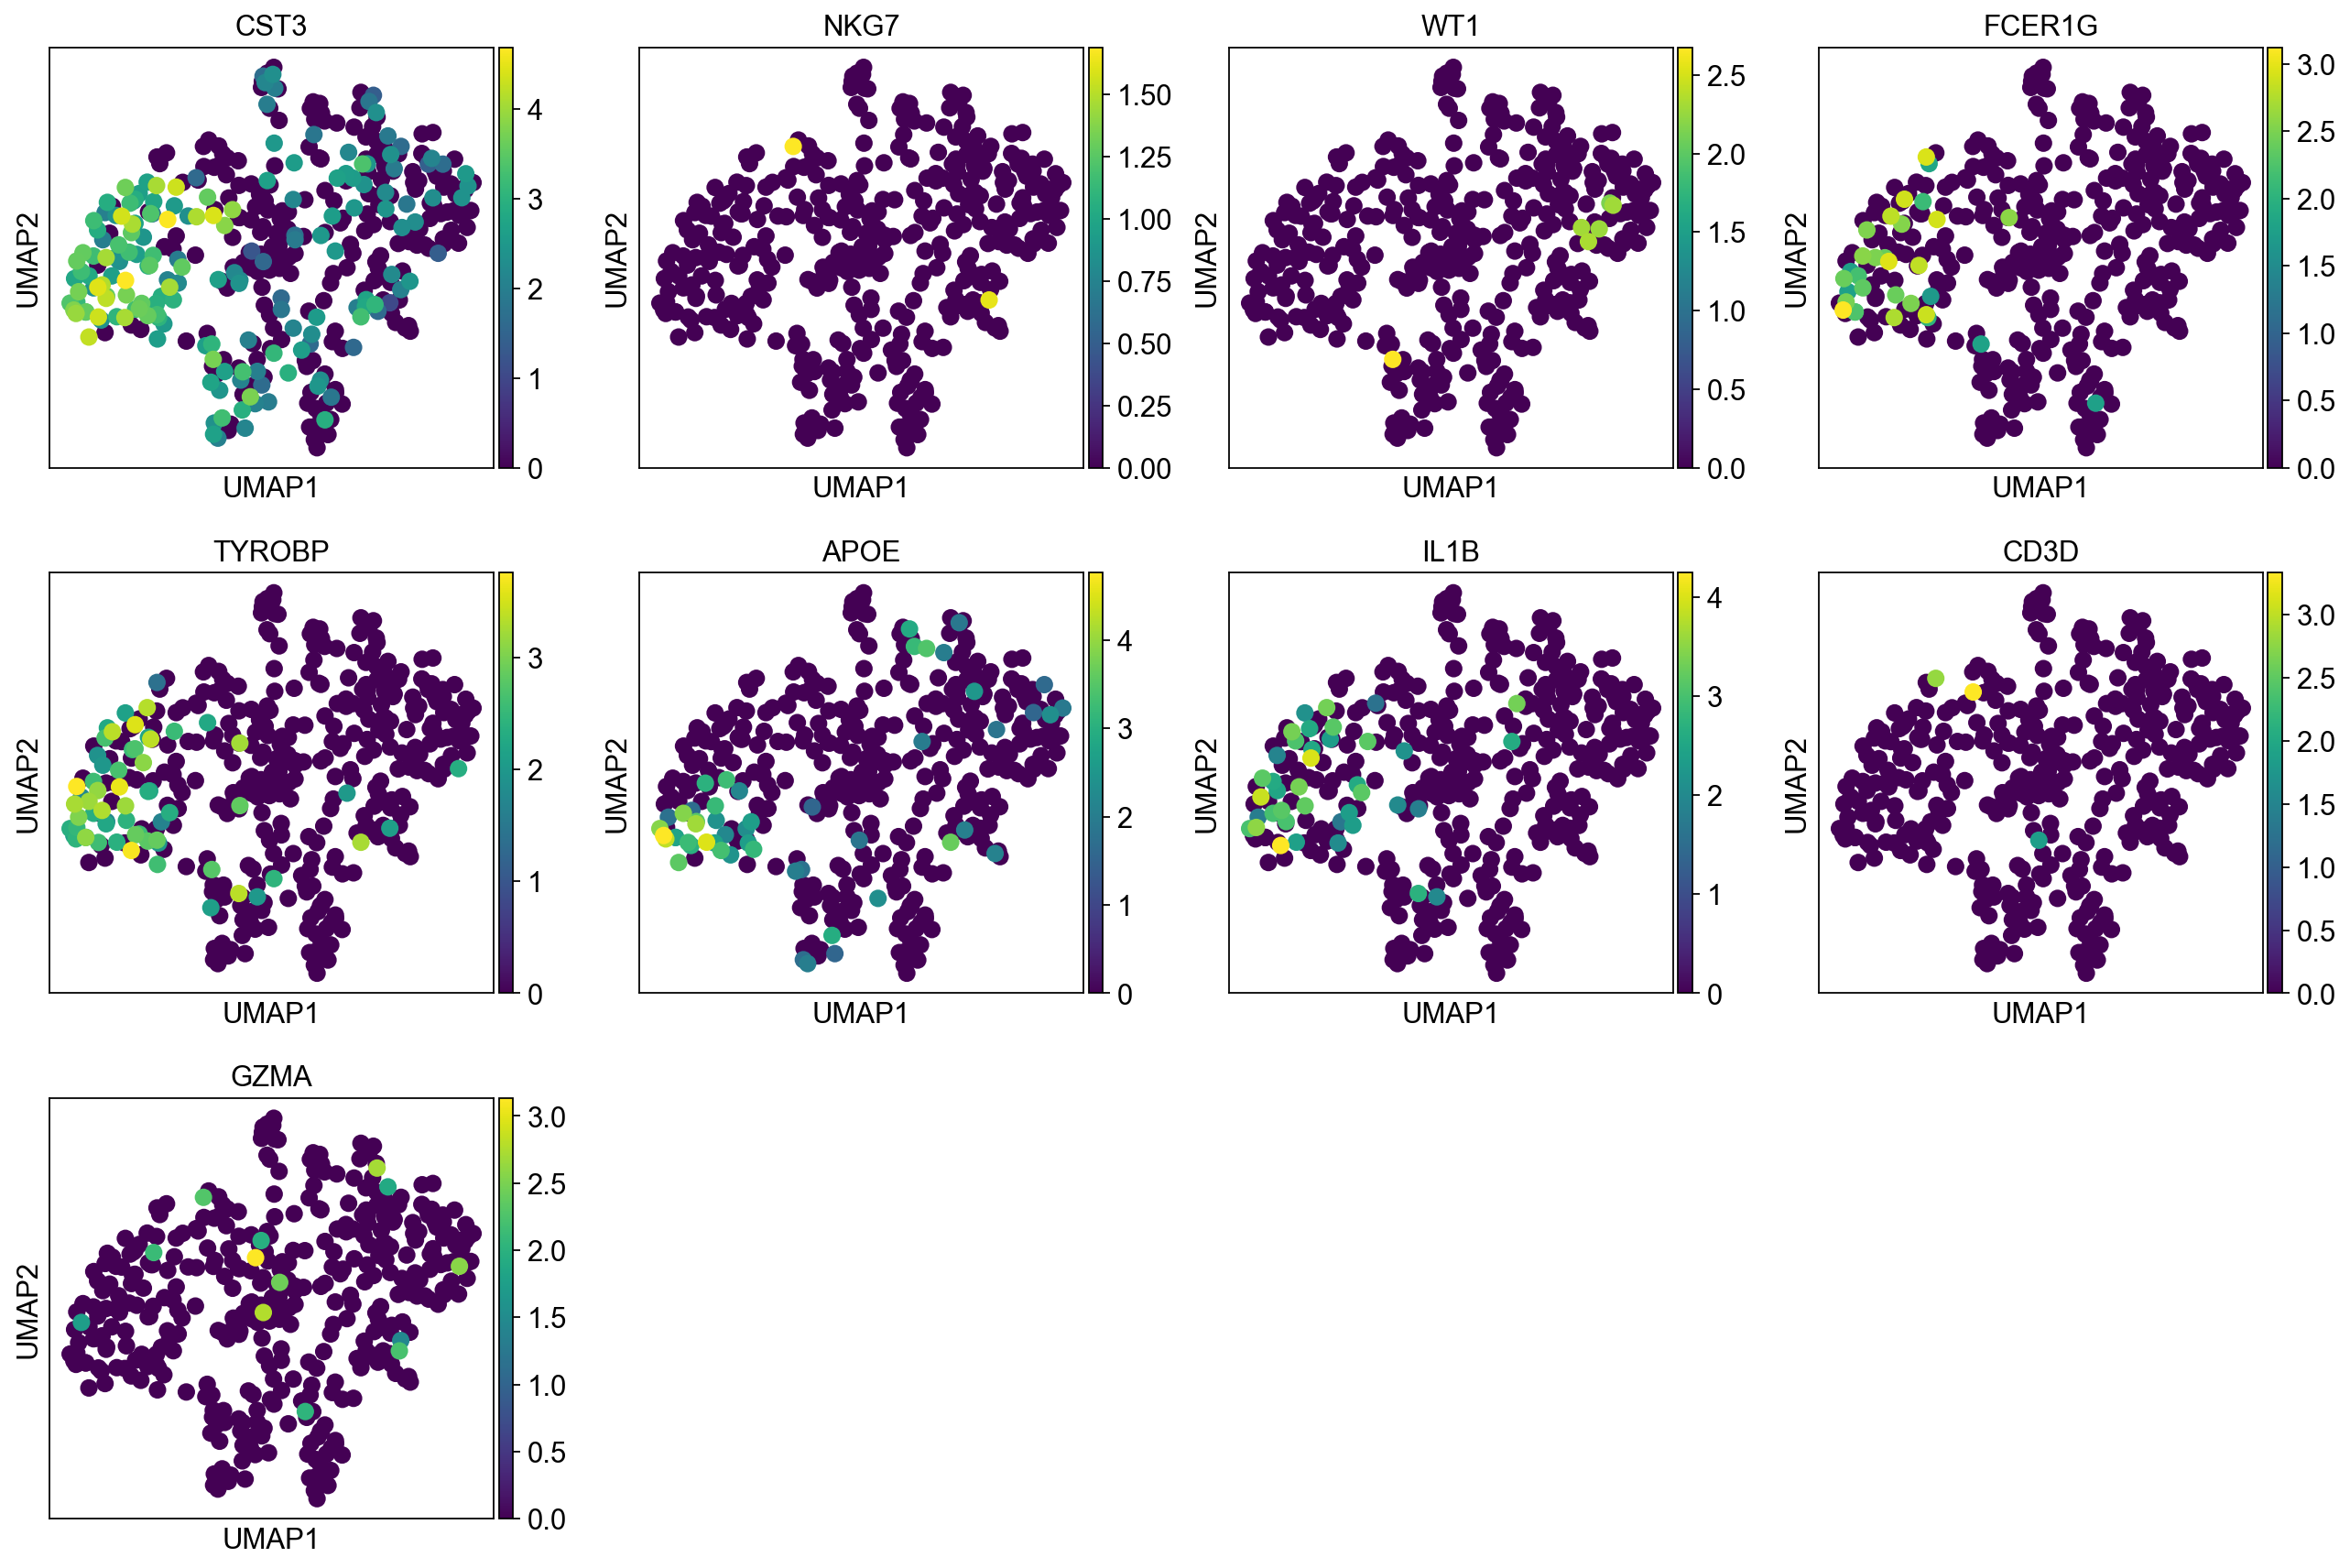

In [38]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'WT1', 'FCER1G', 'TYROBP', 'APOE', 'IL1B', 'CD3D', 'GZMA'])

In [41]:
sc.tl.louvain(adata)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 8 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


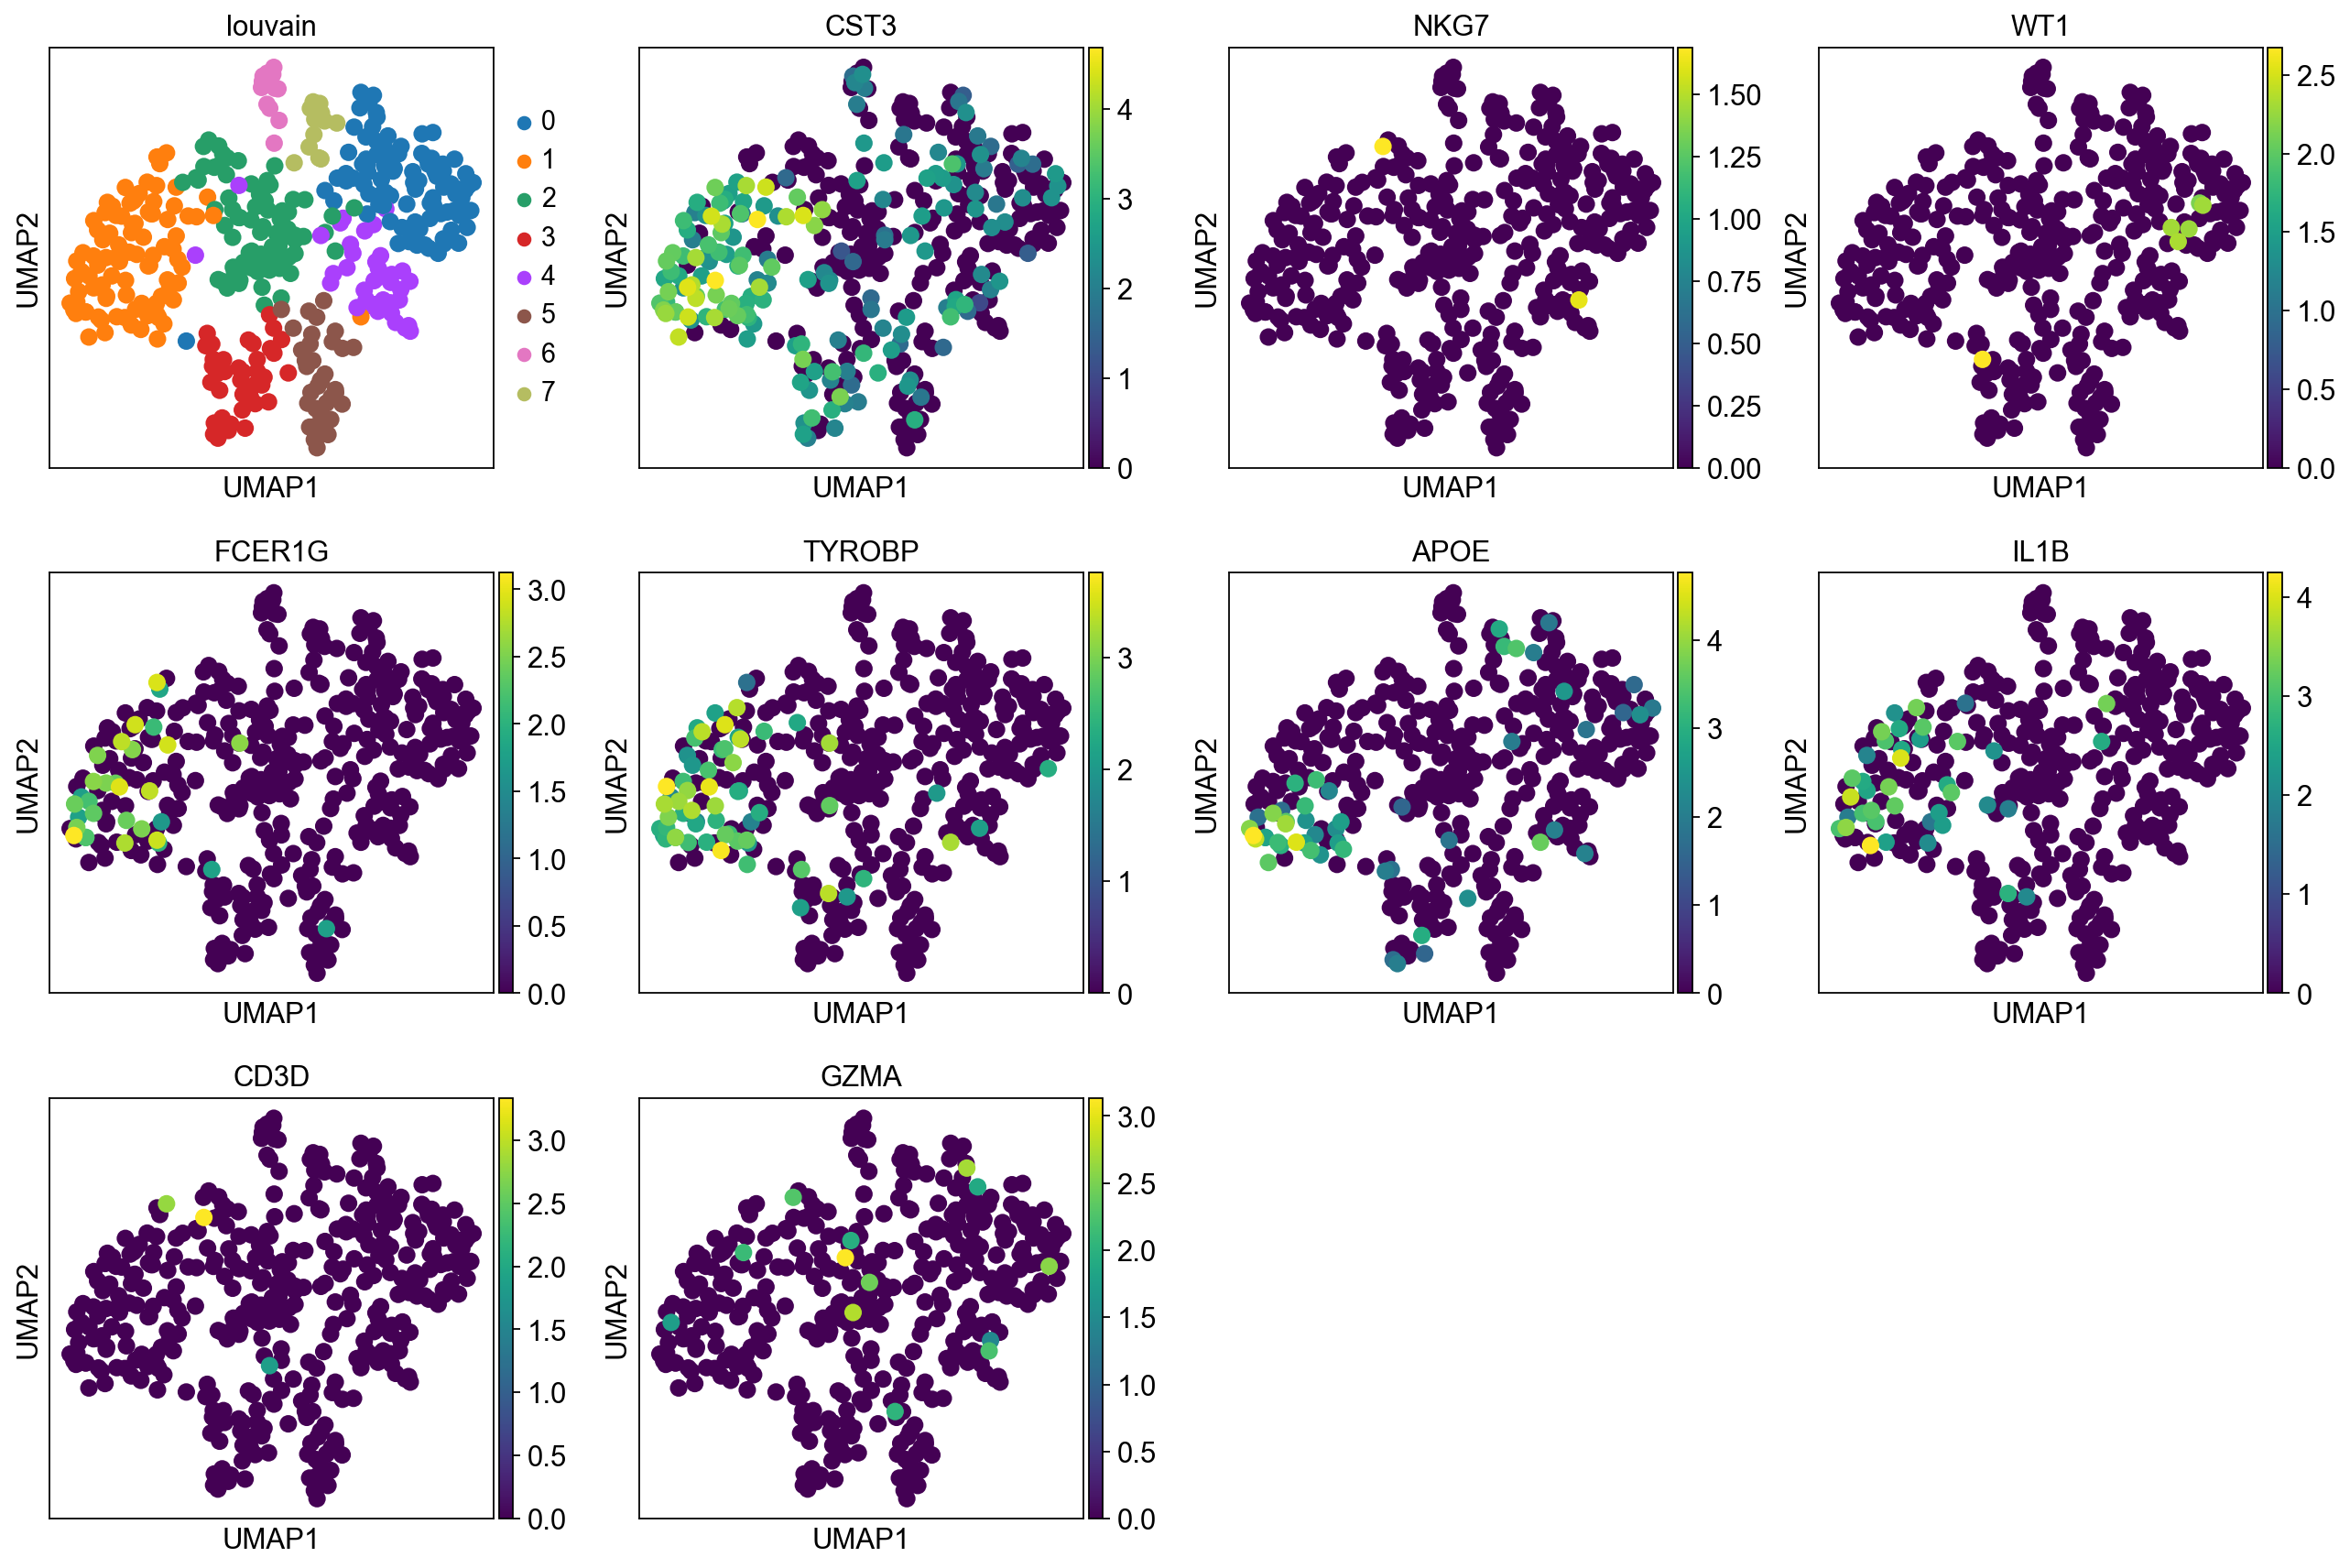

In [42]:
sc.pl.umap(adata, color=['louvain', 'CST3', 'NKG7', 'WT1', 'FCER1G', 'TYROBP', 'APOE', 'IL1B', 'CD3D', 'GZMA'])

In [44]:
adata.write(results_file)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


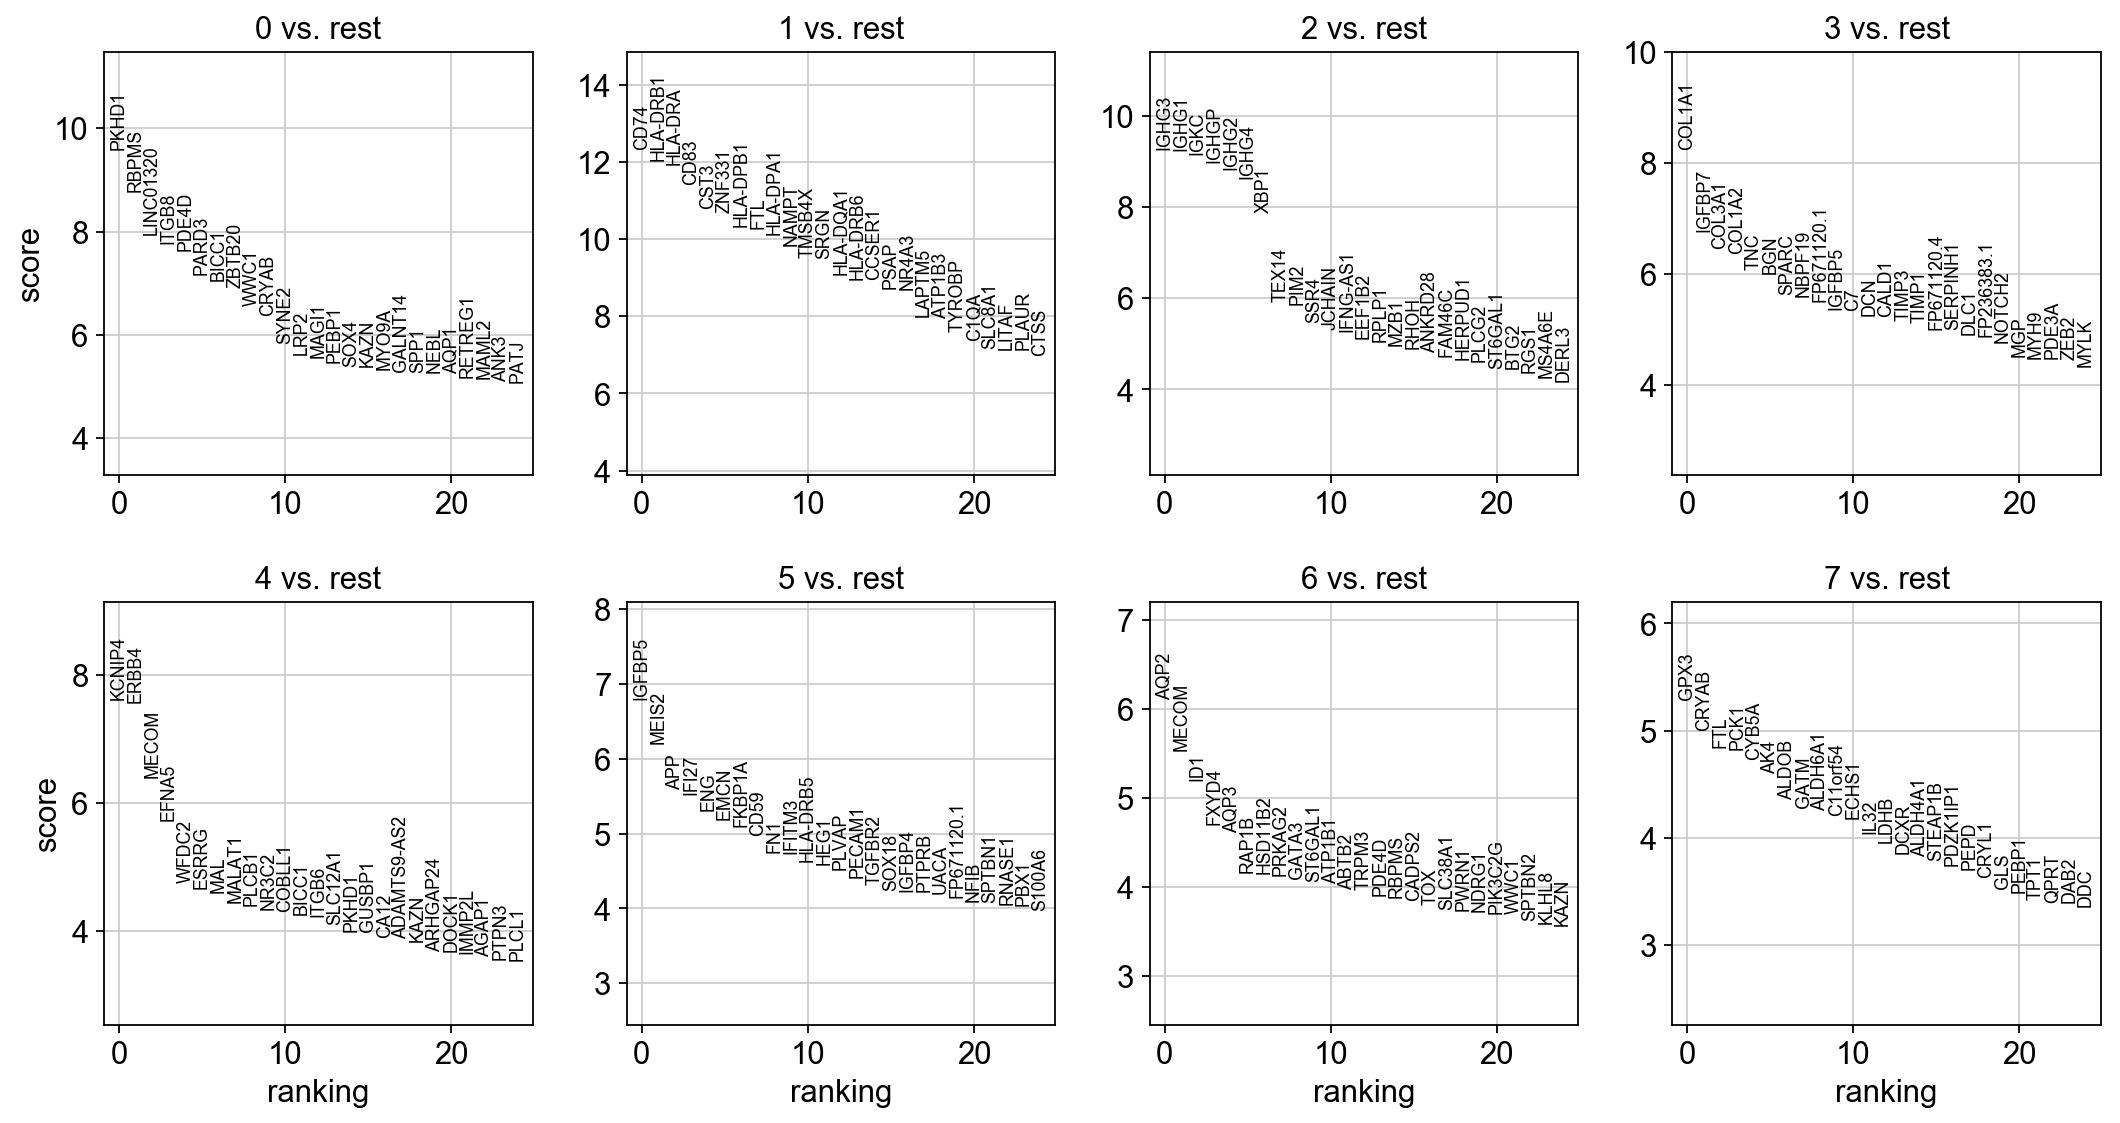

In [45]:
sc.tl.rank_genes_groups(adata, 'louvain', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [47]:
adata.write(results_file)

In [51]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(15)

,0,1,2,3,4,5,6,7
0,PKHD1,CD74,IGHG3,COL1A1,KCNIP4,IGFBP5,AQP2,GPX3
1,RBPMS,HLA-DRB1,IGHG1,IGFBP7,ERBB4,MEIS2,MECOM,CRYAB
2,LINC01320,HLA-DRA,IGKC,COL3A1,MECOM,APP,ID1,FTL
3,ITGB8,CD83,IGHGP,COL1A2,EFNA5,IFI27,FXYD4,PCK1
4,PDE4D,CST3,IGHG2,TNC,WFDC2,ENG,AQP3,CYB5A
5,PARD3,ZNF331,IGHG4,BGN,ESRRG,EMCN,RAP1B,AK4
6,BICC1,HLA-DPB1,XBP1,SPARC,MAL,FKBP1A,HSD11B2,ALDOB
7,ZBTB20,FTL,TEX14,NBPF19,MALAT1,CD59,PRKAG2,GATM
8,WWC1,HLA-DPA1,PIM2,FP671120.1,PLCB1,FN1,GATA3,ALDH6A1
9,CRYAB,NAMPT,SSR4,IGFBP5,NR3C2,IFITM3,ST6GAL1,C11orf54


In [52]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(15)

,0_n,0_p,1_n,1_p,2_n,2_p,3_n,3_p,4_n,4_p,5_n,5_p,6_n,6_p,7_n,7_p
0,PKHD1,8.533596e-22,CD74,6.683373e-35,IGHG3,2.046007e-20,COL1A1,1.612241e-16,KCNIP4,2.561836e-14,IGFBP5,1.098243e-11,AQP2,9.780283e-10,GPX3,1.200982e-07
1,RBPMS,1.749940e-18,HLA-DRB1,2.579773e-33,IGHG1,2.303480e-20,IGFBP7,1.318392e-11,ERBB4,3.810150e-14,MEIS2,5.642479e-10,MECOM,3.020573e-08,CRYAB,5.750605e-07
2,LINC01320,1.881802e-15,HLA-DRA,8.705163e-33,IGKC,5.335394e-20,COL3A1,1.065683e-10,MECOM,1.568639e-10,APP,2.324137e-08,ID1,1.967713e-07,FTL,1.266316e-06
3,ITGB8,8.084775e-15,CD83,3.631315e-30,IGHGP,2.754192e-19,COL1A2,1.826879e-10,EFNA5,9.990863e-09,IFI27,3.251421e-08,FXYD4,2.478105e-06,PCK1,1.399746e-06
4,PDE4D,2.297677e-14,CST3,4.095649e-27,IGHG2,1.063155e-18,TNC,1.206335e-09,WFDC2,2.008532e-06,ENG,1.120559e-07,AQP3,3.814165e-06,CYB5A,2.200077e-06
5,PARD3,7.223729e-13,ZNF331,1.037542e-26,IGHG4,5.975518e-18,BGN,1.783259e-09,ESRRG,3.065366e-06,EMCN,2.159249e-07,RAP1B,3.051912e-05,AK4,4.132822e-06
6,BICC1,1.773947e-12,HLA-DPB1,4.672775e-25,XBP1,3.246234e-15,SPARC,1.722603e-08,MAL,4.214912e-06,FKBP1A,3.382257e-07,HSD11B2,3.250315e-05,ALDOB,1.312679e-05
7,ZBTB20,4.430197e-12,FTL,9.551820e-25,TEX14,3.205998e-09,NBPF19,2.220290e-08,MALAT1,8.534421e-06,CD59,6.435274e-07,PRKAG2,3.589712e-05,GATM,1.852162e-05
8,WWC1,5.419487e-11,HLA-DPA1,3.955817e-24,PIM2,4.672933e-09,FP671120.1,3.787663e-08,PLCB1,1.047412e-05,FN1,2.088972e-06,GATA3,4.087779e-05,ALDH6A1,2.117621e-05
9,CRYAB,1.868683e-10,NAMPT,7.300170e-23,SSR4,4.607777e-08,IGFBP5,8.570602e-08,NR3C2,1.445032e-05,IFITM3,2.270049e-06,ST6GAL1,4.796683e-05,C11orf54,2.542285e-05


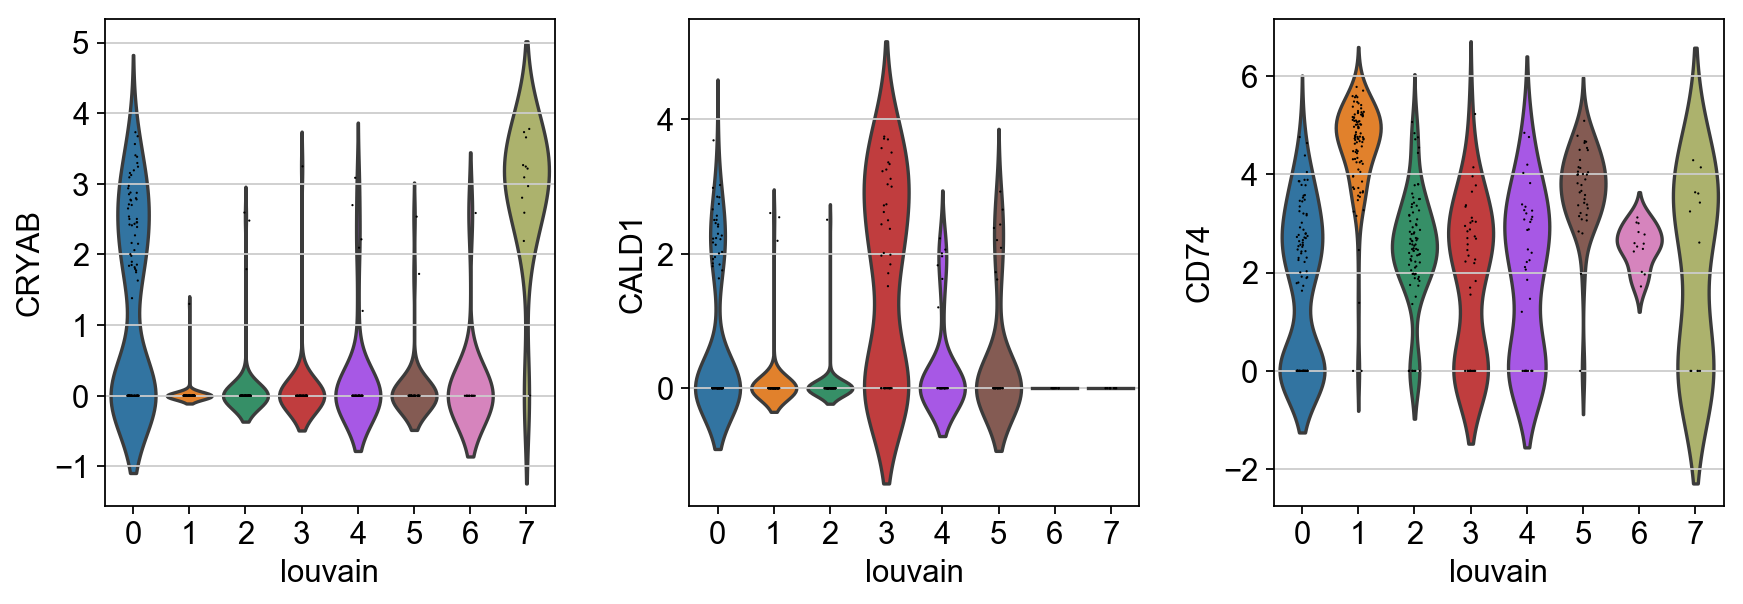

In [54]:
sc.pl.violin(adata, ['CRYAB', 'CALD1', 'CD74'], groupby='louvain')